In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import random
import tqdm  # For progress display
import numpy as np

torch.backends.cudnn.benchmark = True

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# Custom Dataset for Siamese Network
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.classes = self.imageFolderDataset.classes
        self.class_to_idx = self.imageFolderDataset.class_to_idx
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.image_paths = self.imageFolderDataset.imgs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Get an image and its label
        img0_tuple = self.image_paths[index]
        img0_path, label0 = img0_tuple

        # Decide whether to make a positive or negative pair
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # Keep looping till a different image of the same class is found
            while True:
                idx = random.randint(0, len(self.image_paths) - 1)
                img1_tuple = self.image_paths[idx]
                img1_path, label1 = img1_tuple
                if label0 == label1 and img0_path != img1_path:
                    break
        else:
            # Keep looping till an image of a different class is found
            while True:
                idx = random.randint(0, len(self.image_paths) - 1)
                img1_tuple = self.image_paths[idx]
                img1_path, label1 = img1_tuple
                if label0 != label1:
                    break

        # Load images
        img0 = Image.open(img0_path).convert("RGB")
        img1 = Image.open(img1_path).convert("RGB")

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Label is 0 if same class, 1 if different class
        label = torch.tensor([int(label0 != label1)], dtype=torch.float32)

        return img0, img1, label

# Path to your dataset
data_dir = 'imgs'  # Replace with your dataset path

# Create the dataset and dataloader
image_folder_dataset = datasets.ImageFolder(root=data_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=image_folder_dataset,
                                        transform=data_transforms)

train_loader = DataLoader(
    siamese_dataset,
    shuffle=True,
    batch_size=8,   # Increase batch size if GPU memory allows
)

# Define the Siamese Network using ResNet50
class SiameseNetwork_resnet50(nn.Module):
    def __init__(self):
        super(SiameseNetwork_resnet50, self).__init__()
        # Load pretrained ResNet50
        self.model = models.resnet50(pretrained=True)
        # Modify the last layer to output embeddings of size 256
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 256)

    def forward_once(self, x):
        output = self.model(x)
        return output

    def forward(self, input1, input2):
        # Pass both inputs through the network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2




import torch.nn as nn
from torchvision import models

# Define the Siamese Network using VGG16
class SiameseNetwork_vgg16(nn.Module):
    def __init__(self):
        super(SiameseNetwork_vgg16, self).__init__()
        # Load pretrained VGG16
        self.model = models.vgg16(pretrained=True)
        # Modify the classifier to output embeddings of size 256
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 256)
    
    def forward_once(self, x):
        output = self.model(x)
        return output

    def forward(self, input1, input2):
        # Pass both inputs through the network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Compute Euclidean distance between output1 and output2
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        # Compute the contrastive loss
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# Initialize the network, criterion, and optimizer
net = SiameseNetwork_vgg16()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


net.to(device)

criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)




from timeit import default_timer as timer

start = timer()

ll = []

num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i}, Loss {loss.item():.4f}")
            ll.append(loss.item())
    print(f"Epoch {epoch+1} completed, Average Loss: {running_loss/len(train_loader):.4f}")
    torch.save(net.state_dict(), 'siamese_vgg16_'+str(epoch)+'.pth')

end = timer()
print(end - start)


C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Batch 0, Loss 26.9286
Epoch 1/10, Batch 10, Loss 10.6074
Epoch 1/10, Batch 20, Loss 7.1972
Epoch 1/10, Batch 30, Loss 1.9316
Epoch 1/10, Batch 40, Loss 2.3644
Epoch 1/10, Batch 50, Loss 1.0160
Epoch 1/10, Batch 60, Loss 1.1460
Epoch 1/10, Batch 70, Loss 1.0177
Epoch 1/10, Batch 80, Loss 1.0134
Epoch 1/10, Batch 90, Loss 1.0068
Epoch 1/10, Batch 100, Loss 1.0260
Epoch 1/10, Batch 110, Loss 1.0479
Epoch 1/10, Batch 120, Loss 1.0874
Epoch 1/10, Batch 130, Loss 1.0740
Epoch 1/10, Batch 140, Loss 1.0931
Epoch 1/10, Batch 150, Loss 1.0348
Epoch 1/10, Batch 160, Loss 1.0408
Epoch 1/10, Batch 170, Loss 1.2186
Epoch 1/10, Batch 180, Loss 1.0520
Epoch 1/10, Batch 190, Loss 1.0660
Epoch 1/10, Batch 200, Loss 0.9493
Epoch 1/10, Batch 210, Loss 1.0921
Epoch 1/10, Batch 220, Loss 1.0217
Epoch 1/10, Batch 230, Loss 1.1194
Epoch 1/10, Batch 240, Loss 0.9909
Epoch 1/10, Batch 250, Loss 1.0180
Epoch 1/10, Batch 260, Loss 1.0064
Epoch 1/10, Batch 270, Loss 1.0043
Epoch 1/10, Batch 280, Loss 1

KeyboardInterrupt: 

In [2]:
net = SiameseNetwork_vgg16()

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Load the saved state dictionary
net.load_state_dict(torch.load('siamese_vgg16_3.pth', map_location=device))

# Set the model to evaluation mode
net.eval()

C:\Users\Stefan\AppData\Local\Temp\ipykernel_20772\3438666181.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('siamese_vgg16_3.pth', map_l

SiameseNetwork_vgg16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# Load CIFAR-10 dataset
cifar10_dataset = datasets.ImageFolder(root='imgs', transform=transform)
batch_size = 16  # Adjust batch size based on GPU memory
data_loader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=False)




In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import tqdm  # For progress display
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def extract_features_batch(dataloader, model):
    features_db = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, _ in tqdm.tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)  # Move batch of images to device
            batch_features = model.forward_once(images)  # Get features for batch
            batch_features = batch_features.cpu().numpy()  # Move to CPU and convert to numpy
            features_db.append(batch_features)

    # Stack all features into a single array
    return np.vstack(features_db)

def extract_features(image):
    with torch.no_grad():
        features = net.forward_once(image)
        features = features.cpu().numpy().flatten()  # Move to CPU and convert to numpy
        return features


def find_similar_images(query_image_path, features_db, top_n=10):
    

    
    query_image = Image.open(query_image_path).convert('RGB')
    query_image = transform(query_image)
    query_image = query_image.to(device)  # Move query image to device
    query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image


    nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='manhattan').fit(features_db)
    distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
    distances = distances[0]
    indices = indices[0] 
    
    most_similar_indices = indices[:48]
    distances = distances[:48]

    similar_images = [(cifar10_dataset.imgs[idx], 1 - distances[i]) for i, idx in enumerate(most_similar_indices)]
    
    return similar_images

In [5]:
features_db = extract_features_batch(data_loader, net)

Extracting Features: 100%|███████████████████████████████████████████████████████████| 658/658 [01:13<00:00,  8.95it/s]


In [6]:
np.save("features_vgg_contrastive.npy",features_db)

Rank 1, Similarity: 0.999984246911481


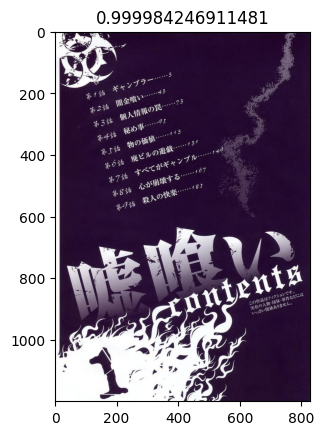

Rank 2, Similarity: -0.4117177724838257


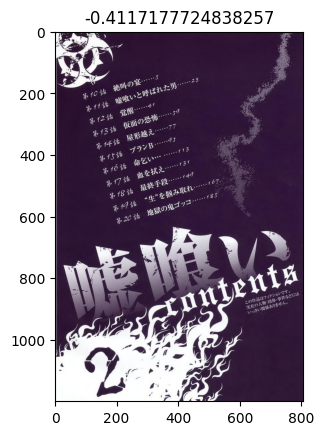

Rank 3, Similarity: -2.761086940765381


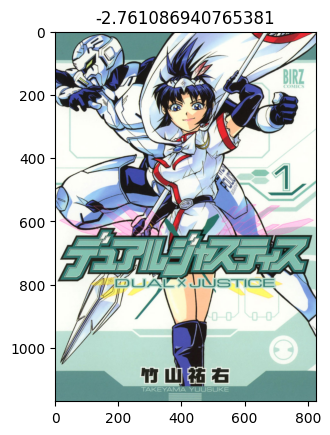

Rank 4, Similarity: -2.8350088596343994


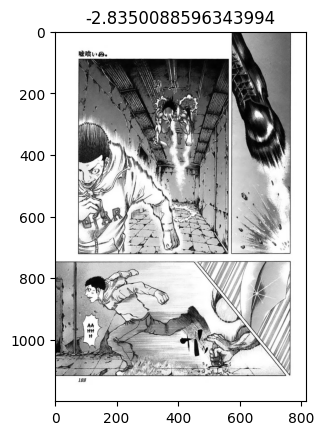

Rank 5, Similarity: -2.8472023010253906


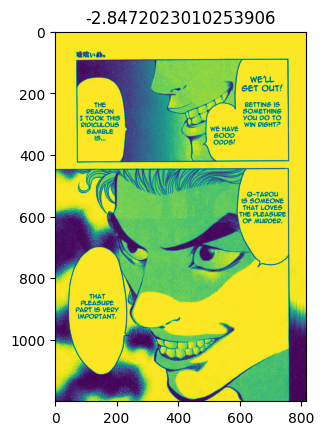

Rank 6, Similarity: -2.854257345199585


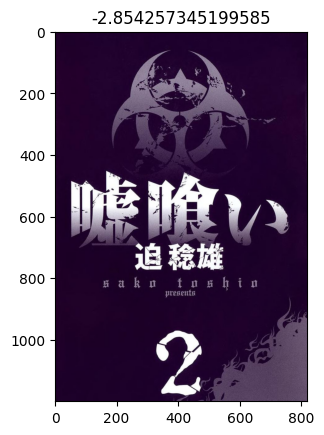

Rank 7, Similarity: -2.997567892074585


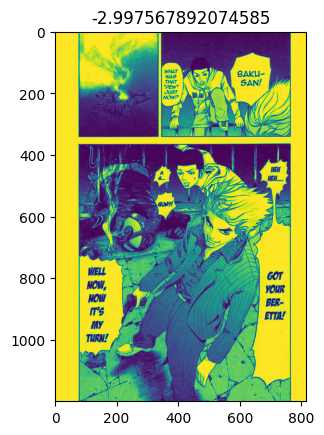

Rank 8, Similarity: -3.0565695762634277


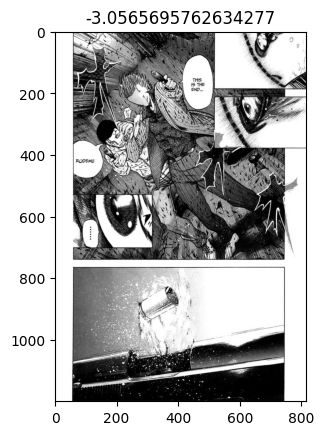

Rank 9, Similarity: -3.068905830383301


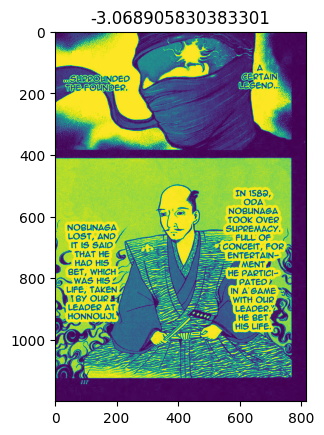

Rank 10, Similarity: -3.0832176208496094


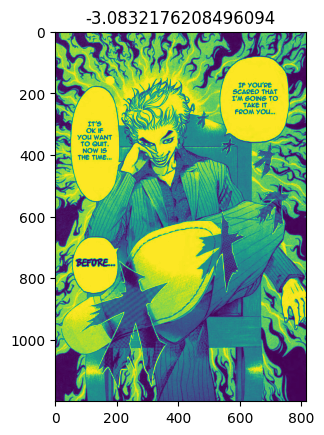

In [7]:

query_image_path = 'imgs/11/v01_0005.jpg'  # Replace with the actual path to the user-provided image
similar_images = find_similar_images(query_image_path, features_db)

# # # Display results
for i, (image_data, similarity) in enumerate(similar_images):
    print(f"Rank {i+1}, Similarity: {similarity}")

     # Convert CIFAR-10 image array to PIL image and display
    original_image = Image.open(image_data[0])
    plt.imshow(original_image)
    plt.title(similarity)
    plt.show()

In [17]:
%%time
import numpy as np
from PIL import Image
import networkx as nx


# Function to build the similarity graph
# Function to build the similarity graph with normalized edge weights
def build_similarity_graph(query_image_path, depth=2, N=2):
    G = nx.Graph()
    visited = set()
    queue = [(query_image_path, 0)]  # (image_path, current_depth)
    while queue:
        current_image_path, current_depth = queue.pop(0)  # BFS
        if current_depth >= depth:
            continue
        if current_image_path in visited:
            continue
        visited.add(current_image_path)

        similar_images = find_similar_images(current_image_path, features_db)

        # Exclude the current image from similar_images
        similar_images = [sim_img for sim_img in similar_images if sim_img[0][0] != current_image_path]

        if not similar_images:
            continue  # Skip if no similar images found

        # Normalize similarities and add edges
        for similar_image in similar_images:
            similar_image_path = similar_image[0][0]
            # Add edge to the graph with normalized weight
            G.add_edge(current_image_path, similar_image_path, weight=similar_image[1])
            queue.append((similar_image_path, current_depth + 1))
    return G


# Usage
query_image_path = 'imgs/11/v01_0003.jpg'
G = build_similarity_graph(query_image_path, depth=3, N=10)

# Now G contains your graph, and you can proceed with the diffusion process


CPU times: user 7.14 s, sys: 29.3 ms, total: 7.17 s
Wall time: 1.18 s


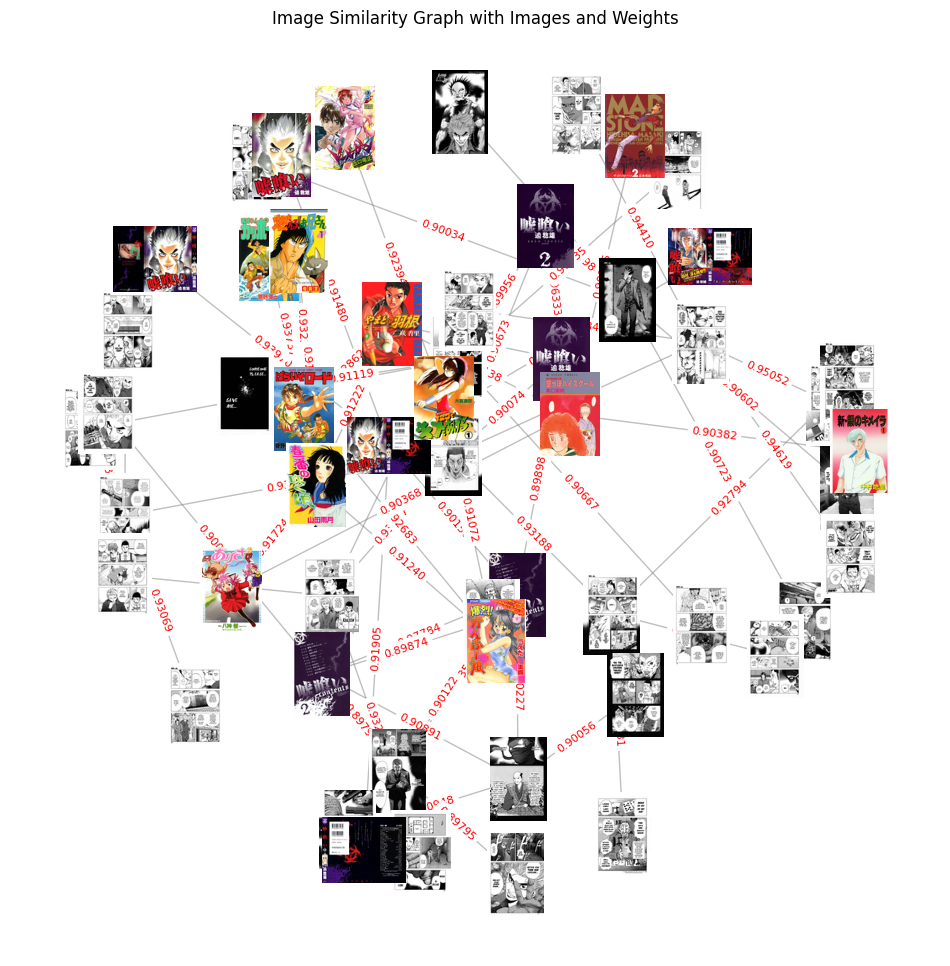

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_graph_with_images_and_weights(G):
    pos = nx.spring_layout(G, k=0.8)
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Draw edges with constant width
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=1)

    # For each node, place the image at its position
    for node in G.nodes():
        x, y = pos[node]
        # Load and resize the image
        try:
            img = Image.open(node).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {node}")
            continue
        img.thumbnail((100, 100), Image.LANCZOS)
        # Create an OffsetImage
        imagebox = OffsetImage(img)
        # Adjust the zoom level if needed
        imagebox = OffsetImage(img, zoom=0.6)
        # Create an AnnotationBbox and add it to the plot
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Prepare edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # Format the weights to have up to 2 decimal places
    formatted_edge_labels = {edge: f"{weight:.5f}" for edge, weight in edge_labels.items()}

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red', font_size=8)

    # Remove axes and display the plot
    plt.axis('off')
    plt.title("Image Similarity Graph with Images and Weights")
    plt.show()

# Call the function to visualize the graph
visualize_graph_with_images_and_weights(G)
